## Introduction

In this notebook, we explore the use of machine learning techniques for music recognition. Specifically, we focus on utilizing Mel-Frequency Cepstral Coefficients (MFCCs), a popular feature used in audio processing and speech recognition tasks, to train models that can accurately classify and recognize music. The analysis compares various model architectures and MFCC lengths to determine the optimal settings for accurate music classification. Evaluation metrics such as accuracy, precision, and recall are employed to assess the performance of the models.

In [3]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from sklearn.model_selection import train_test_split

## Experimentation
### Load the audio files for classification

- GTZAN dataset

A collection of 10 genres with 100 audio files each, all having a length of 30 seconds

In [4]:
# Load all files from a directory
def load_files(directory, dur = 30):
    """
    Load all wav files from a directory and cut them into segments of dur seconds

    Args:
        directory (str): The directory to load the files from
        dur (int): The duration of each segment in seconds

    Returns:
        pandas.DataFrame: The dataframe with the information of the songs
    """
    audio_files = librosa.util.find_files(directory, ext=['wav'])

    df_songs = pd.DataFrame(columns=['Name', 'Genre', 'Segments', 'Sample_Rate'])
    for audio_file in audio_files:
        # Load the audio
        try:
            y, sr = librosa.load(audio_file, duration=30)
        except:
            print("Error loading file: " + audio_file)
            continue

        if dur != 30:
            # Cut the audio into segments of dur seconds
            y_segments = np.array_split(y, int(y.shape[0] / (dur * sr)))

            # Add the segments to the dataframe
            for j in range(len(y_segments)):
                df_songs.loc[len(df_songs)] = [audio_file.split('\\')[-1], audio_file.split('\\')[-2], y_segments[j], sr]
        else:
            df_songs.loc[len(df_songs)] = [audio_file.split('\\')[-1], audio_file.split('\\')[-2], y, sr]

    return df_songs


song_duration = 3
df_songs = load_files('genres_original', dur=song_duration)

df_songs.shape

(9981, 4)

### Visualize the audio data in a spectrogram

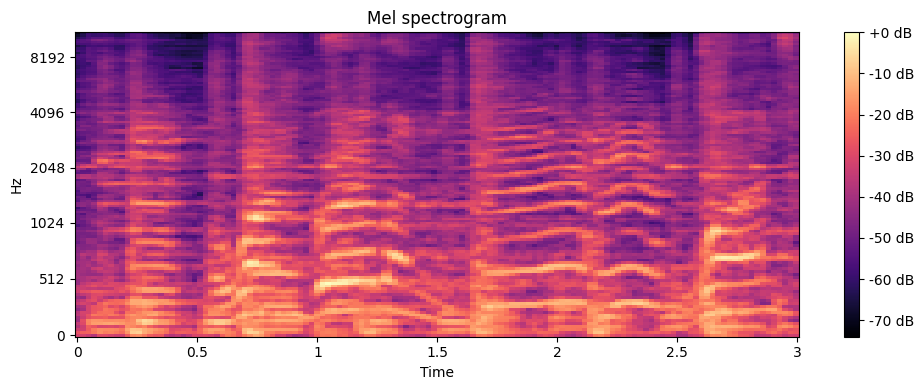

In [5]:
mel_spec = librosa.feature.melspectrogram(y=df_songs['Segments'].iloc[0], sr=df_songs['Sample_Rate'].iloc[0], n_mels=128, fmax=8000)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec_db, sr=df_songs['Sample_Rate'].iloc[0], x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()

### Convert data into a tensor

#### MFCC

MFCCs are a set of features derived from audio signals that are particularly useful for speech and sound recognition tasks. They represent the short-term power spectrum of a sound, emphasizing features that are most relevant to human auditory perception, such as pitch and tone. By transforming raw audio into a small set of features, MFCCs enable machine learning models to efficiently learn and classify different types of sounds.

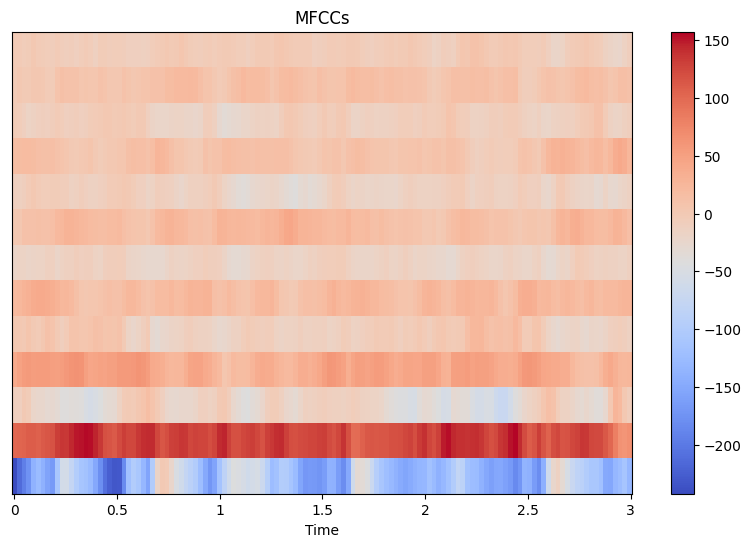

In [6]:
# Extract MFCC features
mfccs = librosa.feature.mfcc(y=df_songs['Segments'].iloc[0], sr=df_songs['Sample_Rate'].iloc[0], n_mfcc=13)

# Display MFCC
plt.figure(figsize=(10, 6))
librosa.display.specshow(mfccs, sr=df_songs['Sample_Rate'].iloc[0], x_axis='time')
plt.colorbar()
plt.title('MFCCs')
plt.show()

In [7]:
# Add a new column with the MCC features
df_songs['Features'] = df_songs['Segments'].apply(lambda x: np.expand_dims(librosa.feature.mfcc(y=x, sr=df_songs['Sample_Rate'].iloc[0], n_mfcc=13).T, axis=-1))
df_songs['num_features'] = df_songs['Features'].apply(lambda x: x.shape[0])

df_songs.head()

,Name,Genre,Segments,Sample_Rate,Features,num_features
0,blues.00000.wav,blues,"[0.0073242188, 0.016601562, 0.0076293945, -0.0...",22050,"[[[-242.43599], [102.18486], [-9.913233], [39....",130
1,blues.00000.wav,blues,"[-0.024810791, -0.020050049, -0.0357666, -0.04...",22050,"[[[-171.76076], [86.718704], [-12.977953], [40...",130
2,blues.00000.wav,blues,"[0.062561035, 0.024353027, -0.004058838, -0.07...",22050,"[[[-129.16685], [107.058235], [-7.277686], [61...",130
3,blues.00000.wav,blues,"[0.2104187, 0.18704224, 0.13729858, 0.06713867...",22050,"[[[-107.022514], [125.82657], [-12.617558], [0...",130
4,blues.00000.wav,blues,"[0.17449951, 0.17346191, 0.15603638, 0.1347961...",22050,"[[[-124.805534], [134.35342], [1.0681027], [16...",130


In [8]:
# Count the different number of features
max_num_features = df_songs['num_features'].value_counts().sort_values(ascending=False)

# Get the number of features with the most occurrences
max_num_features

num_features
130    9900
144      81
Name: count, dtype: int64

In [9]:
# Drop the rows that have features with different shapes than the most common
df_songs = df_songs[df_songs['num_features'] == max_num_features.index[0]]

df_songs.shape

(9900, 6)

<Axes: title={'center': 'Number of songs per genre'}, xlabel='Genre'>

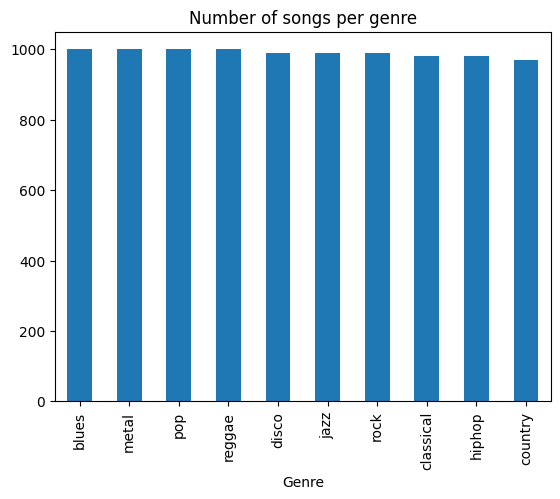

In [10]:
# Show a bar chart with the number of songs per genre
df_songs['Genre'].explode().value_counts().plot(kind='bar', title='Number of songs per genre')

<Axes: title={'center': 'Percentage of songs per genre'}, ylabel='count'>

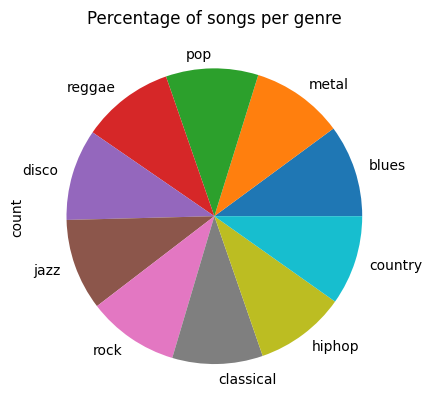

In [11]:
# Show how many songs we have of each genre in a pie chart
df_songs['Genre'].explode().value_counts().plot(kind='pie', title='Percentage of songs per genre')

### Define the model

#### Convolutional Neural Network

Convolutional neural networks are distinguished from other neural networks by their superior performance with image, speech, or audio signal inputs. They have three main types of layers, which are:
- Convolutional layer
- Pooling layer
- Fully-connected (FC) layer

The convolutional layer is the first layer of a convolutional network. While convolutional layers can be followed by additional convolutional layers or pooling layers, the fully-connected layer is the final layer. With each layer, the CNN increases in its complexity, identifying greater portions of the image. Earlier layers focus on simple features, such as colors and edges. As the image data progresses through the layers of the CNN, it starts to recognize larger elements or shapes of the object until it finally identifies the intended object. [IBM](https://www.ibm.com/topics/convolutional-neural-networks)

#### Conv2D (2D Convolutional Layer)

Conv2D is a Keras layer that applies a 2D convolution operation over an input signal (usually an image). In this layer, a set of filters (also known as kernels) is convolved with the input image to detect various features, such as edges, textures, and patterns.

- The convolution operation is applied by sliding the filters (small square matrices) over the input image. For each position, a dot product is computed between the filter and the corresponding portion of the image, producing a single number.
- This process is repeated across the entire image, producing a 2D feature map for each filter.

#### MaxPooling2D (2D Max Pooling Layer)

MaxPooling2D is a pooling layer that reduces the spatial dimensions (height and width) of the input feature maps, while retaining the most important information. Pooling layers help in downsampling the input and reducing the computational load for subsequent layers.

- The MaxPooling operation slides a window over the input feature map and selects the maximum value from each region covered by the window.
- The output is a downsampled version of the input, reducing the size but keeping the most dominant features.

In [12]:
# Define the input shape from the MFCC features
input_shape = df_songs['Features'].iloc[0].shape

# Define the model
model = Sequential()

# Add Convolutional layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output of the convolutional layers
model.add(Flatten())

# Add a dense layer for classification
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer for classification into the number of genres
num_genres = len(df_songs['Genre'].unique())
model.add(Dense(num_genres, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', 'f1_score'])

# Model summary
model.summary()

c:\Users\mario\source\Inteligencia_Artificial\tf-env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 11, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 5, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 3, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1984)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       254,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 274,186 (1.05 MB)

 Trainable params: 274,186 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_songs['Features'].tolist(), df_songs['Genre'], test_size=0.2, random_state=42, shuffle=True)

# Convert the labels to one-hot encoding
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

# Convert the data to tensors
X_train = tf.stack(X_train)
X_test = tf.stack(X_test)

# Train the model
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))

model

Epoch 1/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - Precision: 0.4203 - Recall: 0.0997 - accuracy: 0.2530 - f1_score: 0.2369 - loss: 3.9324 - val_Precision: 0.6579 - val_Recall: 0.2263 - val_accuracy: 0.4162 - val_f1_score: 0.3710 - val_loss: 1.5900
Epoch 2/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - Precision: 0.6795 - Recall: 0.1789 - accuracy: 0.3723 - f1_score: 0.3508 - loss: 1.7164 - val_Precision: 0.7849 - val_Recall: 0.2303 - val_accuracy: 0.4606 - val_f1_score: 0.4338 - val_loss: 1.4362
Epoch 3/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - Precision: 0.6927 - Recall: 0.2223 - accuracy: 0.4286 - f1_score: 0.4151 - loss: 1.5391 - val_Precision: 0.7104 - val_Recall: 0.2763 - val_accuracy: 0.4500 - val_f1_score: 0.3956 - val_loss: 1.4755
Epoch 4/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - Precision: 0.7273 - Recall: 0.2737 - accuracy: 0.4770 - f1_score: 0.4634 - loss: 1.4215 - val_Precision: 0.6935 - val_Recall: 0.2434 - val_accuracy: 0.4429 - val_f1_score: 0.4137 - val_

<Sequential name=sequential, built=True>

## Results

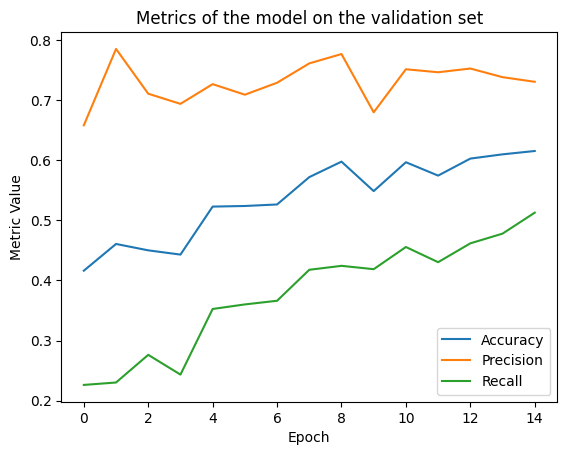

In [14]:
# Plot the model metrics for accuracy, precision, recall
plt.plot(model.history.history['val_accuracy'], label='Accuracy')
plt.plot(model.history.history['val_Precision'], label='Precision')
plt.plot(model.history.history['val_Recall'], label='Recall')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Metrics of the model on the validation set')
plt.show()

#### Confusion Matrix

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


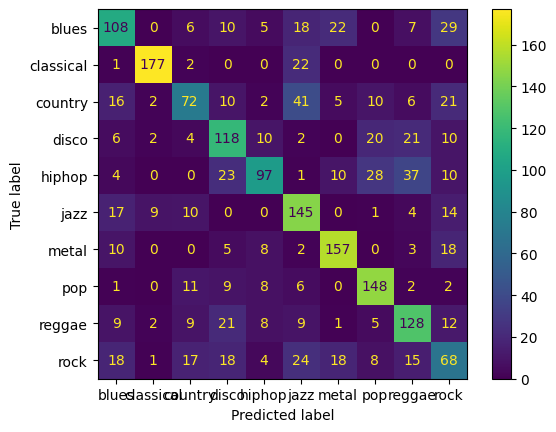

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

# Predict the labels of the test set
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=df_songs['Genre'].unique())

### ROC curve

In [16]:
# Plot the ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import plotly.express as px

binary_testLabels = label_binarize(y_true, classes=range(len(df_songs['Genre'].unique())))

y_pred = model.predict(X_test)

fig = px.line()

for i in range(len(df_songs['Genre'].unique())):
    fpr, tpr, thresholds = roc_curve(binary_testLabels[:, i],
                                     y_pred[:, i])
    roc_auc = auc(fpr, tpr)

    fig.add_scatter(x=fpr, y=tpr, name=f'{df_songs["Genre"].unique()[i]} (AUC = {roc_auc:.2f})', mode="lines")

fig.update_layout(title="ROC curve", xaxis_title="False Positive Rate", yaxis_title="True Positive Rate", showlegend=True)

fig.show()

62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


### Experiment with different songs

In [17]:
def predict_song(song_path, model, offset = 0, clip_duration = 30, end_time = 30):
    """
    Predict the genre of a song

    Args:
        song_path (str): Path to the song
        model (tf.keras.Model): The model to use
        offset (int, optional): The offset of the song in seconds. Defaults to 0.
        clip_duration (int, optional): The duration of each segment of the song in seconds. Defaults to 30.
        end_time (int, optional): The end time of the song in seconds. Defaults to 30.

    Returns:
        str: The predicted genre
    """
    # Load the song
    y, sr = librosa.load(song_path, offset=offset, duration=end_time - end_time % 3, sr=df_songs['Sample_Rate'].iloc[0])

    # Cut the audio into segments of dur seconds
    y_segments = np.array_split(y, int(y.shape[0] / (clip_duration * sr)))

    pred_temp = []
    for y_segment in y_segments:
        try:
            # Transform the audio to a set of mfccs
            mfcc = np.expand_dims(librosa.feature.mfcc(y=y_segment, sr=sr, n_mfcc=13).T, axis=-1)
            
            # Predict the genre
            y_pred = model.predict(tf.stack([mfcc]), verbose=0)

            # Add the predicted genre to the list
            pred_temp.append(y_pred)
        except:
            continue

    return pred_temp

pred = predict_song('songs/FourSeasons.wav', model, clip_duration=song_duration, end_time=180)

px.bar(x=df_songs['Genre'].unique(), y=np.mean(pred, axis=0)[0], title='Predicted genre')

In [18]:
pred = predict_song('songs/WithoutMe.wav', model, offset=15, clip_duration=song_duration, end_time=180)

px.bar(x=df_songs['Genre'].unique(), y=np.mean(pred, axis=0)[0], title='Predicted genre')

In [19]:
pred = predict_song('songs/LP.wav', model, offset=0, clip_duration=song_duration, end_time=181)

px.bar(x=df_songs['Genre'].unique(), y=np.mean(pred, axis=0)[0], title='Predicted genre')

### Comparison between different sized Inputs

In [17]:
def try_song_length(song_length):
    """
    Try different song lengths to find the best performance
    """
    print("Song length: " + str(song_length), end="\r", flush=True)

    # Load the data
    df_temp = load_files('genres_original', dur=song_length)

    # Add the features
    df_temp['Features'] = df_temp['Segments'].apply(lambda x: np.expand_dims(librosa.feature.mfcc(y=x, sr=df_temp['Sample_Rate'].iloc[0], n_mfcc=13).T, axis=-1))
    df_temp['num_features'] = df_temp['Features'].apply(lambda x: x.shape[0])

    # Remove rows that have features with different shapes than the most common
    max_num_features = df_temp['num_features'].value_counts().sort_values(ascending=False)
    df_temp = df_temp[df_temp['num_features'] == max_num_features.index[0]]

    # Create the model
    input_shape = df_temp['Features'].iloc[0].shape
    model_temp = Sequential()
    model_temp.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model_temp.add(MaxPooling2D(pool_size=(2, 2)))
    model_temp.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model_temp.add(MaxPooling2D(pool_size=(2, 2)))
    model_temp.add(Flatten())
    model_temp.add(Dense(128, activation='relu'))
    model_temp.add(Dropout(0.5))
    num_genres = len(df_temp['Genre'].unique())
    model_temp.add(Dense(num_genres, activation='softmax'))
    model_temp.compile(optimizer='adam', loss='categorical_crossentropy',
                metrics=['accuracy', 'Precision', 'Recall'])
    
    # Train the model
    X_train, X_test, y_train, y_test = train_test_split(df_temp['Features'].tolist(), df_temp['Genre'], test_size=0.2, random_state=42, shuffle=True)
    y_train = pd.get_dummies(y_train)
    y_test = pd.get_dummies(y_test)
    X_train = tf.stack(X_train)
    X_test = tf.stack(X_test)

    model_temp.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    # Return the metrics of the model
    return model_temp.history.history

# Try different song lengths and plot the results
song_lengths = [1, 2, 3, 5, 6, 10, 15, 30]
metrics = {"Accuracy": [], "Precision": [], "Recall": [], "Song length": song_lengths}
for length in song_lengths:
    model_temp = try_song_length(length)
    metrics["Accuracy"].append(model_temp["val_accuracy"][-1])
    metrics["Precision"].append(model_temp["val_Precision"][-1])
    metrics["Recall"].append(model_temp["val_Recall"][-1])

metrics

c:\Users\mario\source\Inteligencia_Artificial\tf-env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



c:\Users\mario\source\Inteligencia_Artificial\tf-env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



c:\Users\mario\source\Inteligencia_Artificial\tf-env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



c:\Users\mario\source\Inteligencia_Artificial\tf-env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



c:\Users\mario\source\Inteligencia_Artificial\tf-env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



c:\Users\mario\source\Inteligencia_Artificial\tf-env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



c:\Users\mario\source\Inteligencia_Artificial\tf-env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



c:\Users\mario\source\Inteligencia_Artificial\tf-env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



{'Accuracy': [0.6464646458625793,
  0.6323232054710388,
  0.6419191956520081,
  0.5555555820465088,
  0.5181818008422852,
  0.5101010203361511,
  0.43686869740486145,
  0.36000001430511475],
 'Precision': [0.7974537014961243,
  0.7798319458961487,
  0.7745839357376099,
  0.7220447063446045,
  0.6960784196853638,
  0.6117318272590637,
  0.5637065768241882,
  0.4032258093357086],
 'Recall': [0.4639730751514435,
  0.46868687868118286,
  0.5171717405319214,
  0.3804713785648346,
  0.3585858643054962,
  0.36868685483932495,
  0.36868685483932495,
  0.25],
 'Song length': [1, 2, 3, 5, 6, 10, 15, 30]}

In [18]:
# Plot the metrics of the model [accuracy, precision, recall]
px.line(metrics, x="Song length", y=["Accuracy", "Precision", "Recall"], title='Metrics of the model', range_y=[0, 1])

### Comparison between different sized MFCCs

In [62]:
def try_MFCC_length(mfcc_length):
    """
    Try different MFCC lengths to find the best performance
    """
    print("MFCC length: " + str(mfcc_length), end="\r", flush=True)

    # Add the features
    df_temp = load_files('genres_original', dur=song_duration)
    df_temp['Features'] = df_temp['Segments'].apply(lambda x: np.expand_dims(librosa.feature.mfcc(y=x, sr=df_temp['Sample_Rate'].iloc[0], n_mfcc=mfcc_length).T, axis=-1))
    df_temp['num_features'] = df_temp['Features'].apply(lambda x: x.shape[0])

    # Remove rows that have features with different shapes than the most common
    max_num_features = df_temp['num_features'].value_counts().sort_values(ascending=False)
    df_temp = df_temp[df_temp['num_features'] == max_num_features.index[0]]

    # Create the model
    input_shape = df_temp['Features'].iloc[0].shape
    model_temp = Sequential()
    model_temp.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model_temp.add(MaxPooling2D(pool_size=(2, 2)))
    model_temp.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model_temp.add(MaxPooling2D(pool_size=(2, 2)))
    model_temp.add(Flatten())
    model_temp.add(Dense(128, activation='relu'))
    model_temp.add(Dropout(0.5))
    num_genres = len(df_temp['Genre'].unique())
    model_temp.add(Dense(num_genres, activation='softmax'))
    model_temp.compile(optimizer='adam', loss='categorical_crossentropy',
                metrics=['accuracy', 'Precision', 'Recall'])
    
    # Train the model
    X_train, X_test, y_train, y_test = train_test_split(df_temp['Features'].tolist(), df_temp['Genre'], test_size=0.2, random_state=42, shuffle=True)
    y_train = pd.get_dummies(y_train)
    y_test = pd.get_dummies(y_test)
    X_train = tf.stack(X_train)
    X_test = tf.stack(X_test)

    model_temp.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    # Return the metrics of the model
    return model_temp.history.history

# Try different MFCC lengths and plot the results
mfcc_lengths = [10, 20, 30, 40]
metrics = {"Accuracy": [], "Precision": [], "Recall": [], "MFCC length": mfcc_lengths}

for length in mfcc_lengths:
    model_temp = try_MFCC_length(length)
    metrics["Accuracy"].append(model_temp["val_accuracy"][-1])
    metrics["Precision"].append(model_temp["val_Precision"][-1])
    metrics["Recall"].append(model_temp["val_Recall"][-1])

metrics

c:\Users\mario\source\Inteligencia_Artificial\tf-env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



c:\Users\mario\source\Inteligencia_Artificial\tf-env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



c:\Users\mario\source\Inteligencia_Artificial\tf-env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



c:\Users\mario\source\Inteligencia_Artificial\tf-env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



{'Accuracy': [0.6080808043479919,
  0.6545454263687134,
  0.6277777552604675,
  0.6489899158477783],
 'Precision': [0.7661221027374268,
  0.7483130693435669,
  0.7572209239006042,
  0.7640692591667175],
 'Recall': [0.44999998807907104,
  0.5601010322570801,
  0.4898989796638489,
  0.5348485112190247],
 'MFCC length': [10, 20, 30, 40]}

In [63]:
# Plot the metrics of the model [accuracy, precision, recall]
px.line(metrics, x="MFCC length", y=["Accuracy", "Precision", "Recall"], title='Metrics of the model', range_y=[0, 1])

## Conclusion

Through this analysis, we observed that the size of the MFCCs significantly affects the model's performance. Larger MFCC lengths generally resulted in improved metrics, demonstrating the importance of capturing detailed frequency information in audio recognition tasks. The precision, recall, and accuracy metrics indicate that the models are capable of effectively distinguishing between different music genres or audio samples. Future work may involve experimenting with more complex models or additional feature extraction techniques to further enhance performance.